In [1]:
import os, warnings
from pathlib import Path

import numpy as np
import scanpy as sc
import dynamo as dyn
import spateo as st
warnings.filterwarnings("ignore")

/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packag

In [2]:
cpo = [(393, 1084, 9), (9, 5, -2), (0, 0, 1)]
mapping_cpo = [(-28, 1021, -119), (-29, 9, -152), (0, 0, 1)]

In [3]:
tissue, morpho_id = "amnioserosa", "morphogenesis"
sample_id1, sample_id2 = "E7_8h", "E8_9h"
os.chdir(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot")

out_image_path = f"drosophila_{sample_id1}_germ_layer/image/morphogenesis_{tissue}"
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [7]:
# Read anndata
n_top_genes = 200
stage1_adata = st.read_h5ad(f"drosophila_{sample_id1}/h5ad/{sample_id1}_cellbin_clean.h5ad")
stage1_adata.X = stage1_adata.layers["X_counts"]
stage1_adata.obsm["3d_align_spatial"] = stage1_adata.obsm["tdr_spatial"]
stage1_adata = stage1_adata[stage1_adata.obs["anno_tissue_new"] == tissue, :]
stage1_adata.X = stage1_adata.layers["X_counts"].copy()
stage1_adata = stage1_adata[stage1_adata.X.sum(axis=1) != 0, stage1_adata.X.sum(axis=0) != 0]
sc.pp.highly_variable_genes(stage1_adata, n_top_genes=n_top_genes)
stage1_adata = stage1_adata[:, stage1_adata.var["highly_variable"]]
sc.pp.normalize_total(adata=stage1_adata)
sc.pp.log1p(stage1_adata)

stage2_adata = st.read_h5ad(f"drosophila_{sample_id2}/h5ad/{sample_id2}_cellbin_v2_{tissue}.h5ad")
stage2_adata.X = stage2_adata.layers["X_counts"].copy()
stage2_adata = stage2_adata[stage2_adata.X.sum(axis=1) != 0, stage2_adata.X.sum(axis=0) != 0]
sc.pp.highly_variable_genes(stage2_adata, n_top_genes=n_top_genes)
stage2_adata = stage2_adata[:, stage2_adata.var["highly_variable"]]
sc.pp.normalize_total(adata=stage2_adata)
sc.pp.log1p(stage2_adata)
print(stage1_adata, stage2_adata)

AnnData object with n_obs × n_vars = 769 × 201
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    obsm: '2d_realign_spatial', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial', '3d_align_spatial'
    layers: 'X_counts', 'spliced', 'unspliced' AnnData object with n_obs × n_vars = 969 × 200
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'


## Mapping

In [18]:
# Cell mapping
_, pi = st.tdr.cell_directions(
    adataA=stage1_adata,
    adataB=stage2_adata,
    numItermaxEmd=2000000,
    # G_init=pi_init,
    spatial_key="3d_align_spatial",
    key_added="cells_mapping",
    alpha=0.001,
    device="0",
    inplace=True,
)

|-----> Filtered all samples for common genes. There are 36 common genes.


## Check mapping result

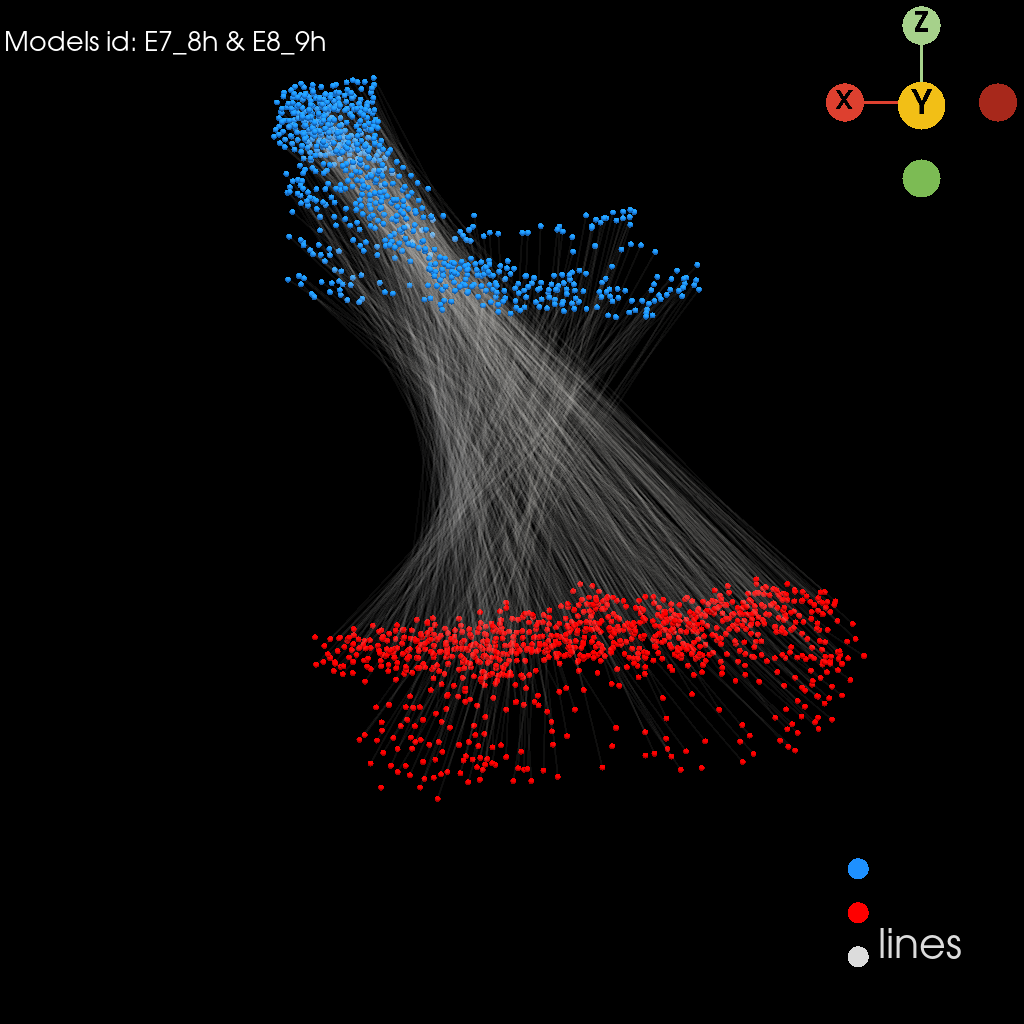

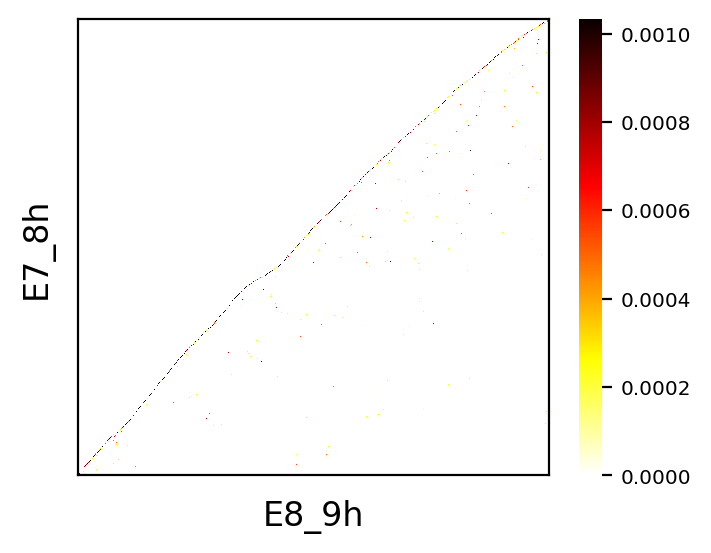

In [19]:
# Check mapping result
st.pl.pi_heatmap(
    pi=pi,
    model1_name=sample_id1,
    model2_name=sample_id2,
    filename=os.path.join(
        out_image_path, f"{sample_id1}-{sample_id2}_{tissue}_mapping_heatmap.png"
    ),
)
st.pl.pairwise_mapping(
    idA=sample_id1,
    idB=sample_id2,
    adataA=stage1_adata.copy(),
    adataB=stage2_adata.copy(),
    pi=pi.copy(),
    spatial_key="3d_align_spatial",
    cpo=mapping_cpo,
    jupyter="static",
    filename=os.path.join(out_image_path, f"{sample_id1}-{sample_id2}_{tissue}_mapping_z_model.png"),
)

## Vector field

In [20]:
stage1_pc = st.tdr.read_model(f"drosophila_{sample_id1}/pc_models/6_Amnioserosa_{sample_id1}_aligned_pc_model.vtk")
stage1_mesh = st.tdr.read_model(f"drosophila_{sample_id1}/mesh_models_new/6_Amnioserosa_{sample_id1}_aligned_mesh_model.vtk")

In [21]:
st.tdr.morphofield_sparsevfc(
    adata=stage1_adata,
    spatial_key="3d_align_spatial",
    V_key="V_cells_mapping",
    key_added="VecFld_morpho",
    NX=np.asarray(stage1_mesh.points),
    inplace=True,
)
stage1_pc.point_data["vectors"] = stage1_adata.uns["VecFld_morpho"]["V"]
stage1_mesh.point_data["vectors"] = stage1_adata.uns["VecFld_morpho"]["grid_V"]

|-----? The length of [  0 100 200 300 400] is different from 10, using `np.range(restart_num) * 100
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [0.0307s]
|-----> [morphofield] in progress: 100.0000%
|-----> [morphofield] finished [39.9864s]


|-----? The number of start_points is more than 500. You may want to lower the max number of arrows to draw.


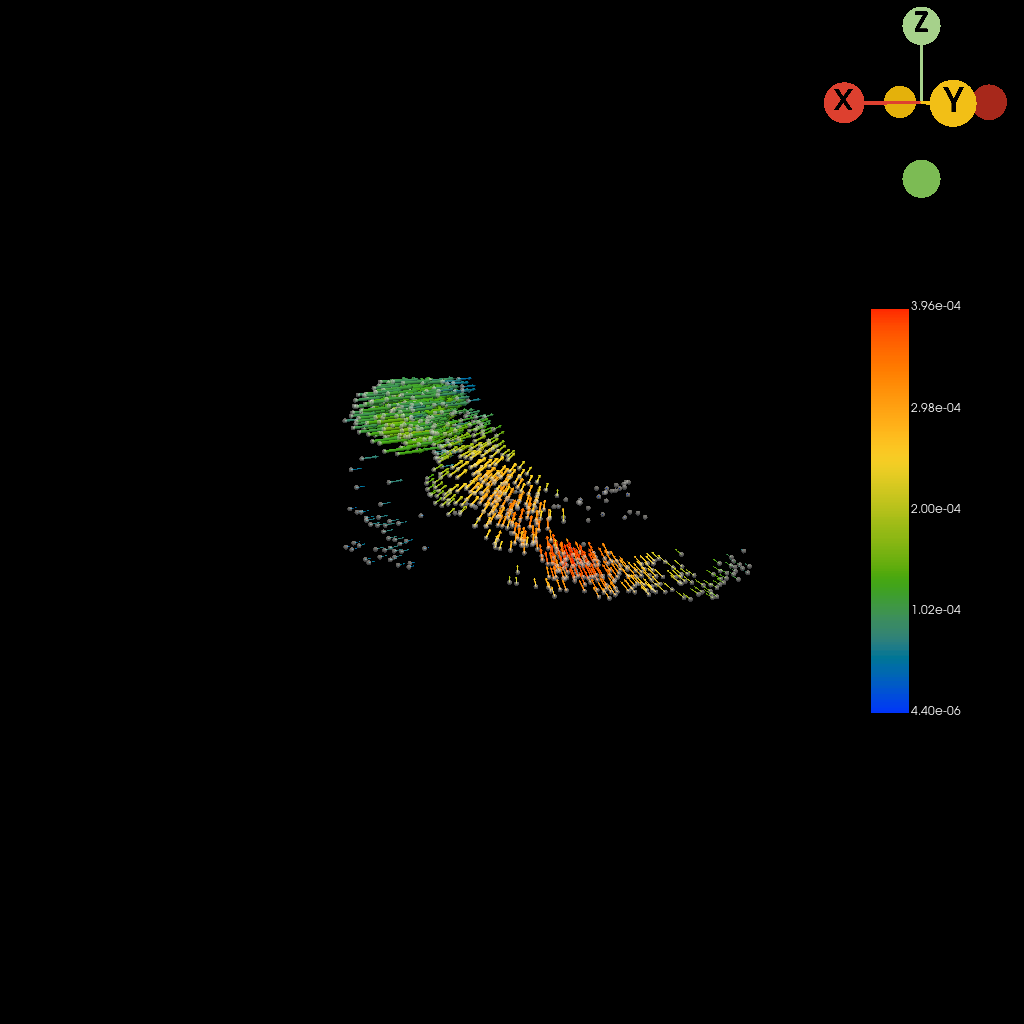

In [22]:
vector_arrows1,_ = st.tdr.construct_field(
    model=stage1_pc,
    vf_key="vectors",
    arrows_scale_key="vectors",
    n_sampling=None,
    factor=20000,
    key_added="v_arrows",
    label=stage1_pc.point_data["vectors"][:, 2].flatten(),
    color= "rainbow",
)
st.pl.three_d_plot(
    model=st.tdr.collect_models([stage1_pc, vector_arrows1]),
    key=["tissue", "v_arrows"],
    colormap=["gainsboro", "rainbow"],
    opacity=[0.5, 1],
    model_style=["points", "surface"],
    model_size=5,
    show_legend=True,
    jupyter="static",
    background="black",
    window_size=(1024, 1024),
    cpo=cpo,
    filename=os.path.join(out_image_path, f"{morpho_id}_{tissue}_vector_arrows_pc_model.pdf")
)

In [25]:
st.tdr.morphopath(
    adata=stage1_adata,
    vf_key="VecFld_morpho",
    key_added="fate_morpho",
    t_end=50000,
    interpolation_num=50,
    cores=20
)
trajectory_model, _ = st.tdr.construct_trajectory(
    adata=stage1_adata,
    fate_key="fate_morpho",
    n_sampling=500,
    sampling_method="trn",
    key_added="obs_index",
    label=np.asarray(stage1_adata.obs.index), # stage1_tissue_adata.uns["VecFld_morpho"]["V"][:, 2].flatten(),
)
stage1_adata.obs["V_z"] = stage1_adata.uns["VecFld_morpho"]["V"][:, 2].flatten()
st.tdr.add_model_labels(
    model=trajectory_model,
    key_added="trajectory",
    labels=np.asarray(stage1_adata[np.asarray(trajectory_model.point_data["obs_index"])].obs["V_z"]),
    colormap="rainbow",
    where="point_data",
    inplace=True,
)
st.pl.three_d_plot(
    model=st.tdr.collect_models([stage1_pc, trajectory_model]),
    key=["tissue", "trajectory"],
    opacity=[0.5, .5],
    model_style=["points", "wireframe"],
    model_size=[5, 2],
    colormap=["gainsboro", "rainbow"],
    show_legend=True,
    jupyter="static",
    background="black",
    window_size=(1024, 1024),
    cpo=cpo,
    filename=os.path.join(out_image_path, f"{morpho_id}_{tissue}_trajectory_pc_model.pdf")
)

Exception: The VecFld_morpho that corresponds to the reconstructed vector field is not in ``anndata.uns``.Please run ``st.tdr.morphofield_gp`` or ``st.tdr.morphofield_sparsevfc`` before fate prediction.

In [24]:
# Save anndata
stage1_adata.X = stage1_adata.layers["X_counts"]
del stage1_adata.uns, stage1_adata.obsp, stage1_adata.var
stage1_adata.uns["__type"] = "UMI"
stage1_adata.write_h5ad(f"drosophila_{sample_id1}_germ_layer/h5ad/{sample_id1}_mapping_{tissue}.h5ad", compression="gzip",)
stage1_adata

AnnData object with n_obs × n_vars = 769 × 201
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z'
    uns: '__type'
    obsm: '2d_realign_spatial', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial', '3d_align_spatial', 'X_cells_mapping', 'V_cells_mapping'
    layers: 'X_counts', 'spliced', 'unspliced'